In [1]:
import numpy as np
import burst_detector as bd
import pandas as pd
import math
import os
import json
import time
import matplotlib.pyplot as plt

%matplotlib inline
%config InlineBackend.figure_format='retina'

In [2]:
params = {}

params["data_filepath"] = "C:/Users/Harris_Lab/Projects/burst-detector/data/midbrain_cullen/NPX_001_Session_2_preprocessed.bin"
params["KS_folder"] =  "C:/Users/Harris_Lab/Projects/burst-detector/data/midbrain_cullen/KS2.5_preprocessed"

params["calc_means"] = True
params["fs"] = 30000
params["n_chan"] = 128
params["pre_samples"] = 20
params["post_samples"] = 62
params["max_spikes"] = 2000

params["skip_cross_sim"] = False

params["jitter"] = True
params["jitter_amt"] = 4
params["sim_thresh"] = 0.4
params["sp_num_thresh"] = 100

params["n_iter"] = 50
params["shuffle_bin_width"] = 0.1
params["window_size"] = 0.01
params["xcorr_bin_width"] = 0.0005
params["overlap_tol"] = 10/30000
params["max_window"] = 0.01
params["min_xcorr_rate"] = 800

params["xcorr_ref_p"] = 0.0005
params["ref_pers"] = [0.001, 0.002]
params["max_viol"] = 0.01

params["xcorr_coeff"] =  0.5
params["ref_pen_coeff"] = 1
params["final_thresh"] = 0.7
params["max_dist"] = 10

In [3]:
times = np.load(os.path.join(params['KS_folder'], 'spike_times.npy')).flatten()
clusters = np.load(os.path.join(params['KS_folder'], 'spike_clusters.npy')).flatten() 
n_clust = clusters.max() + 1

counts = bd.spikes_per_cluster(clusters)
labels = pd.read_csv(os.path.join(params['KS_folder'], 'cluster_group.tsv'), sep="\t")

In [4]:
rawData = np.memmap(params['data_filepath'], dtype='int16', mode='r')
data = np.reshape(rawData, (int(rawData.size/params['n_chan']), params['n_chan']))
mean_wf = None

In [5]:
times_multi = bd.find_times_multi(times, clusters, np.arange(clusters.max()+1))

mean_sim, offset, wf_means_norm, mean_wf, pass_ms = bd.stages.calc_mean_sim(
        data, 
        times_multi, 
        clusters, 
        counts, 
        n_clust,
        labels,
        mean_wf,
        params
)
print("Found %d candidate cluster pairs" % (pass_ms.sum()/2))

Found 170 candidate cluster pairs


In [6]:
spikes = {}
num = 0
for c1 in range(n_clust):
    for c2 in range(c1+1, n_clust):
        if pass_ms[c1,c2]:
            num += 1

            if c1 not in spikes:
                spikes[c1] = bd.extract_spikes(
                    data, 
                    times_multi, 
                    clusters, 
                    c1, 
                    pre_samples=params['pre_samples'],
                    post_samples=params['post_samples'],
                    n_chan=params['n_chan'],
                    max_spikes=params['max_spikes']
                )
            if c2 not in spikes:
                spikes[c2] = bd.extract_spikes(
                    data, 
                    times_multi, 
                    clusters, 
                    c2, 
                    pre_samples=params['pre_samples'],
                    post_samples=params['post_samples'],
                    n_chan=params['n_chan'],
                    max_spikes=params['max_spikes']
                )
data = None

In [7]:
cross_sim = bd.stages.calc_cross_sim(spikes, wf_means_norm,\
                                             offset, pass_ms, n_clust)
spikes = None

In [8]:
xcorr_sig, xgrams, shfl_xgrams = bd.stages.calc_xcorr_metric(
        times, 
        clusters,
        n_clust, 
        pass_ms, 
        params
)

In [9]:
ref_pen, ref_per = bd.stages.calc_ref_p(times, clusters, n_clust, pass_ms, xcorr_sig,\
                                   params)

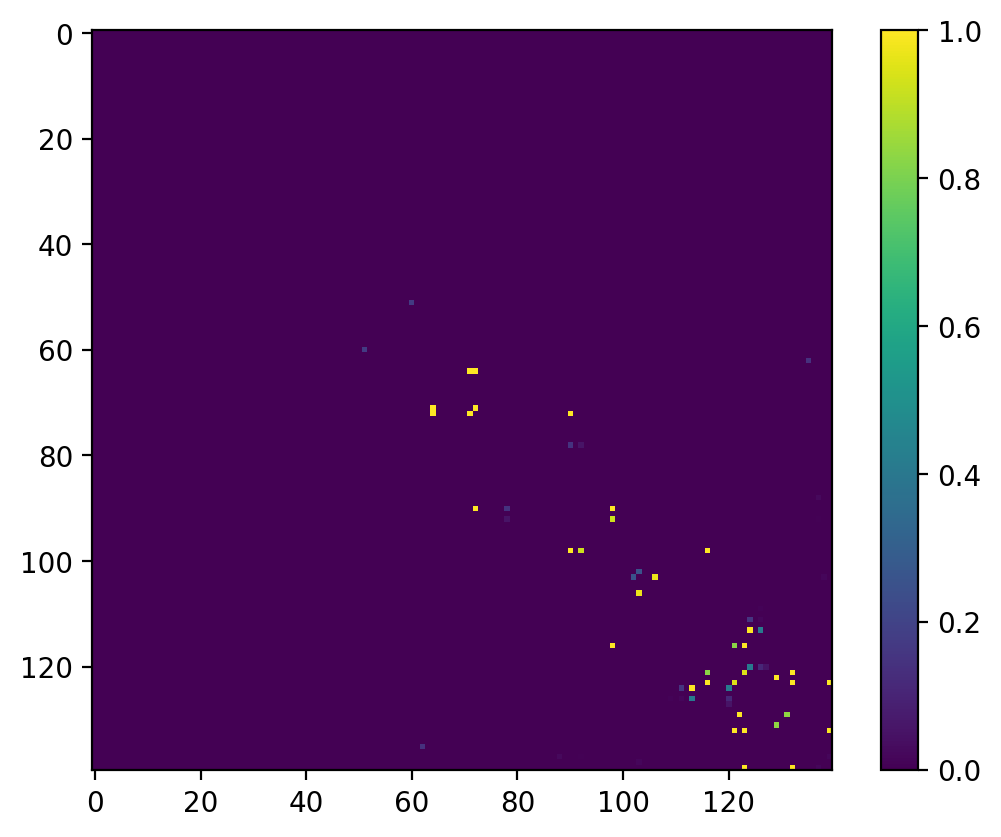

In [10]:
plt.imshow(ref_pen); plt.colorbar();

In [11]:
final_metric = np.zeros_like(mean_sim)
    
for c1 in range(n_clust):
    for c2 in range(c1, n_clust):
        met = np.sqrt(cross_sim[c1,c2] * cross_sim[c2,c1]) + \
        params['xcorr_coeff']*xcorr_sig[c1,c2] - \
        params['ref_pen_coeff']*ref_pen[c1,c2]

        final_metric[c1,c2] = max(met, 0)
        final_metric[c2,c1] = max(met, 0)

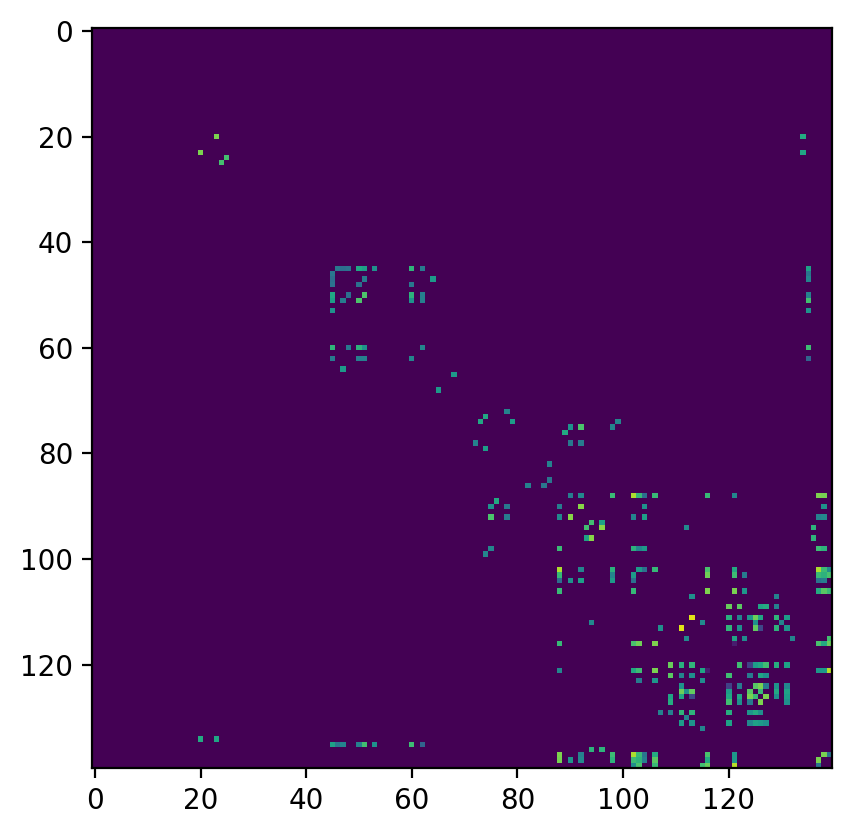

In [12]:
plt.imshow(final_metric, vmin=0, vmax=1.2);

In [13]:
channel_map = np.load(os.path.join(params['KS_folder'], 'channel_map.npy')).flatten()
    
clusters, co, merge_lists, stage_mets = bd.stages.merge_clusters(
    times, clusters, counts, n_clust, final_metric, cross_sim, xcorr_sig, 
    ref_pen, mean_wf, channel_map, params)

In [14]:
old2new = merge_lists[0].copy()

# fix old2new
for key, value in old2new.items():
    if value in old2new.keys():
        while value in old2new.keys():
            value = old2new[value]
        old2new[key] = value

trash = []
for key in old2new.keys():
    if int(key) >= final_metric.shape[0]:
        trash.append(key)
        
for key in trash:
    del old2new[key]

new2old = {}

for key, value in old2new.items():
    if (value in new2old.keys()):
        new2old[value].append(int(key))
    else:
        new2old[value] = [int(key)]

In [15]:
mean_sim[113,129]

0.7854270828526533

In [16]:
new2old

{162: [111, 113, 129],
 161: [121, 139, 115],
 164: [102, 88, 137, 138, 98],
 143: [92, 90],
 166: [96, 94, 93, 136],
 157: [106, 116, 103],
 146: [127, 126],
 163: [20, 23, 134],
 158: [120, 109, 122],
 150: [124, 125],
 165: [51, 50, 135, 60, 45],
 152: [25, 24],
 154: [76, 89],
 155: [74, 73]}

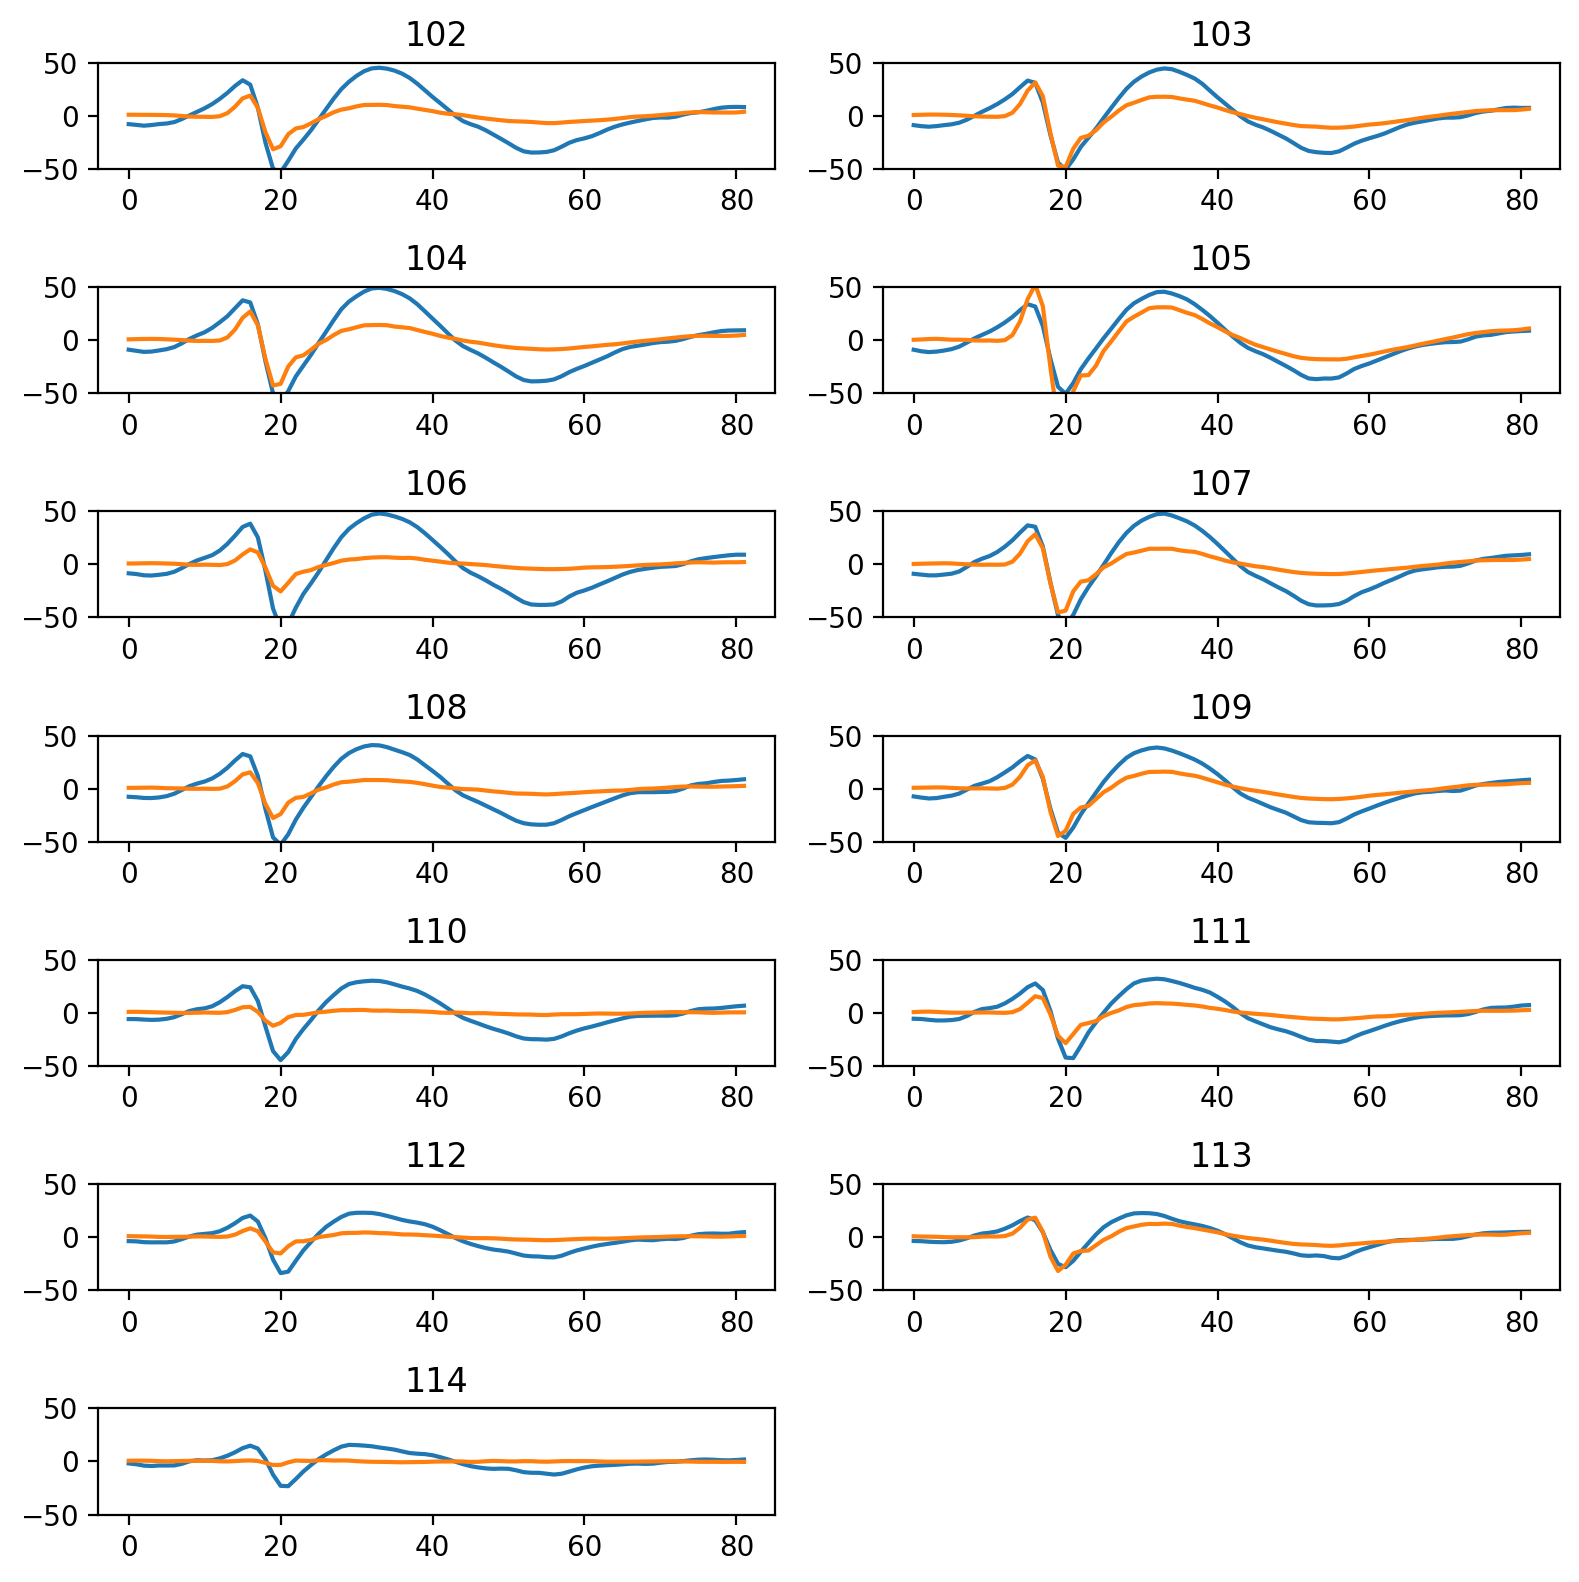

In [17]:
plt.figure(figsize=(8,8))
for i in range(102, 115):
    plt.subplot(7, 2, i+1-102)
    plt.title(i)
    plt.plot(mean_wf[113,i, :])
    plt.plot(mean_wf[129,i, :])
    plt.ylim([-50, 50])
    
plt.tight_layout()

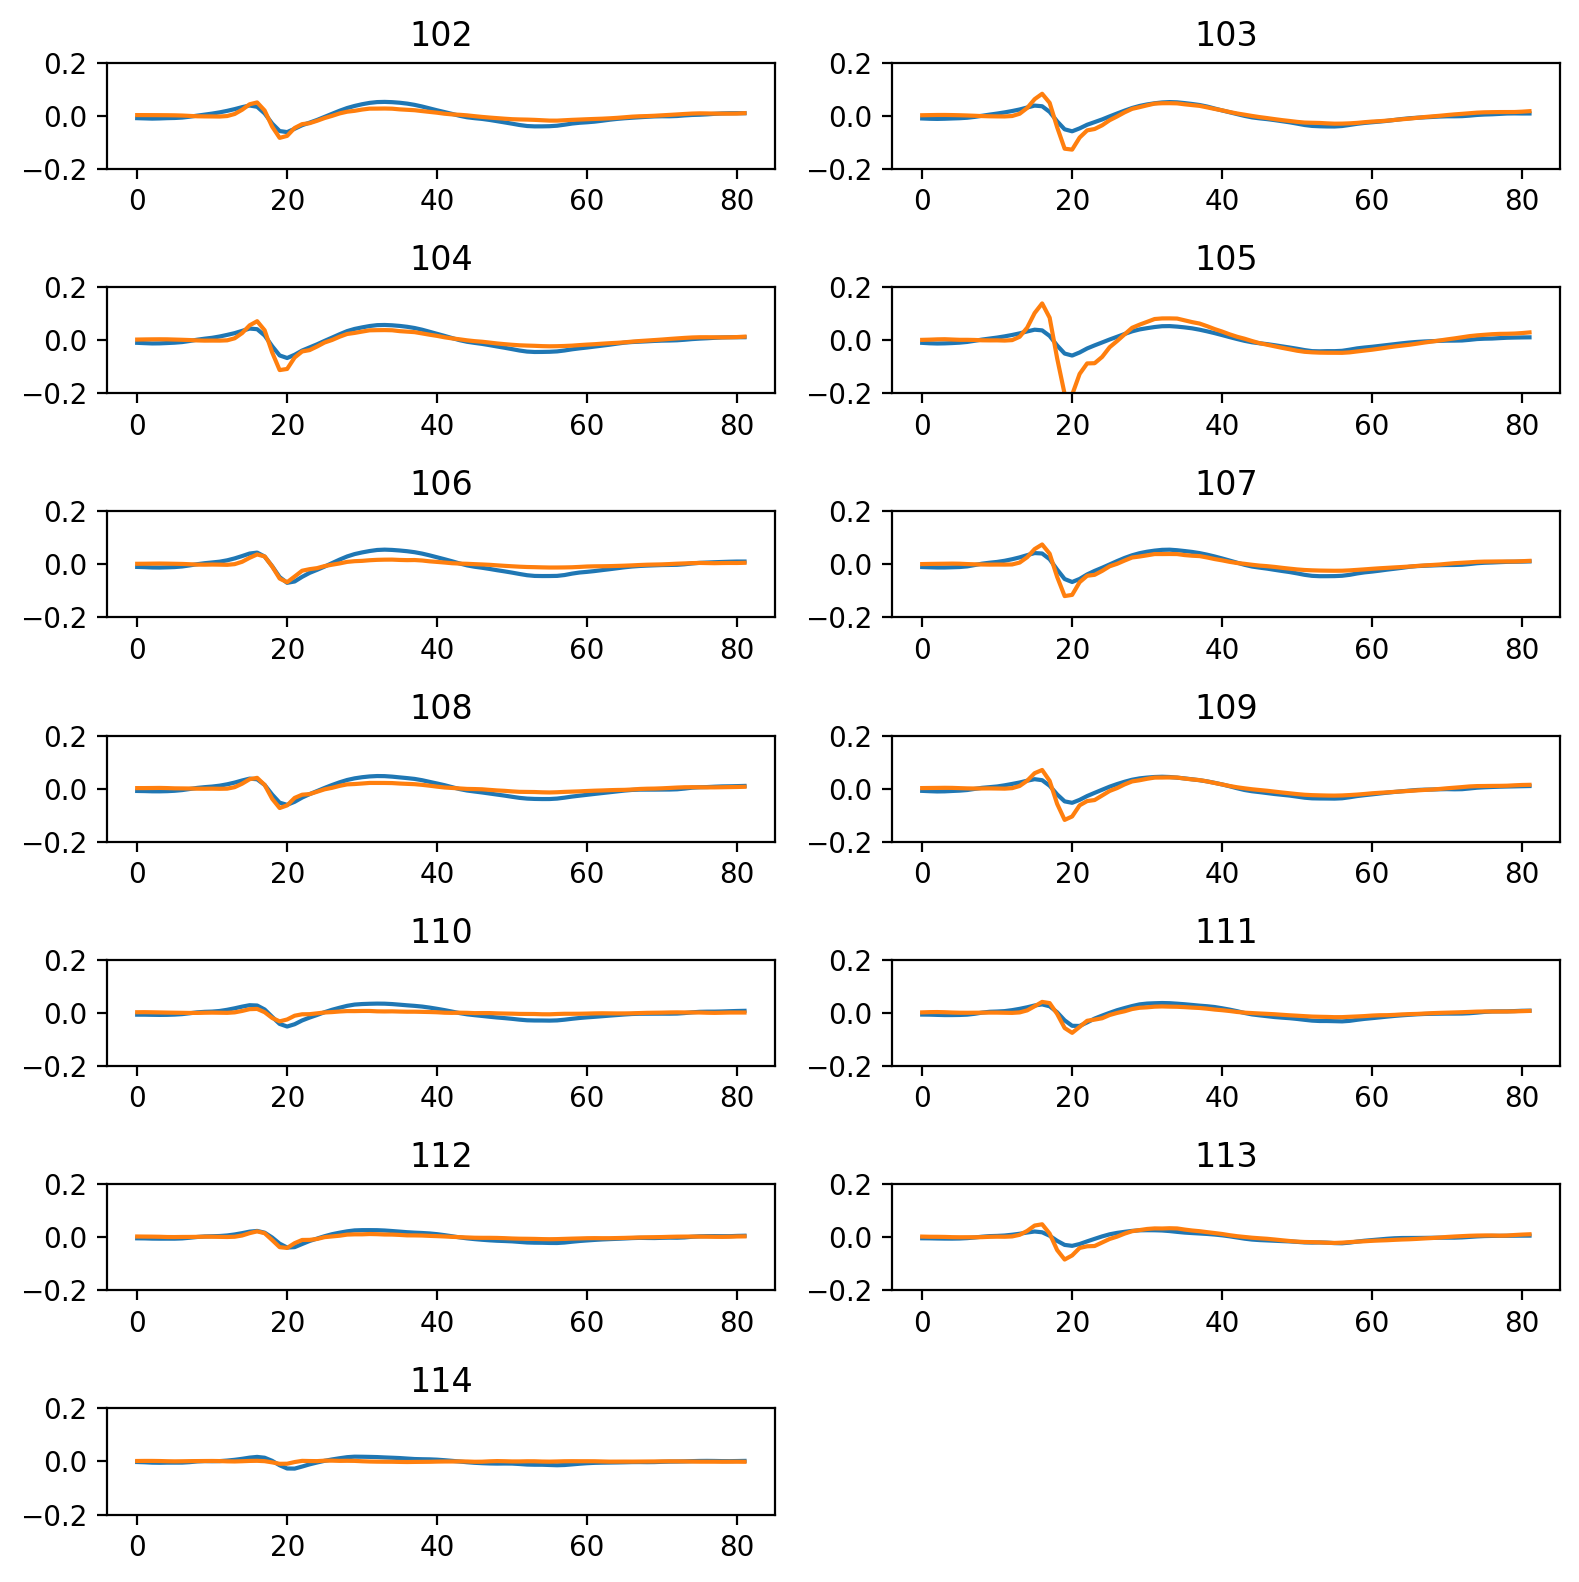

In [18]:
mean_wf_norm = bd.normalize_wfs(mean_wf)

plt.figure(figsize=(8,8))
for i in range(102, 115):
    plt.subplot(7, 2, i+1-102)
    plt.title(i)
    plt.plot(mean_wf_norm[113,i, :])
    plt.plot(mean_wf_norm[129,i, :])
    plt.ylim([-0.2, 0.2])
    
plt.tight_layout()

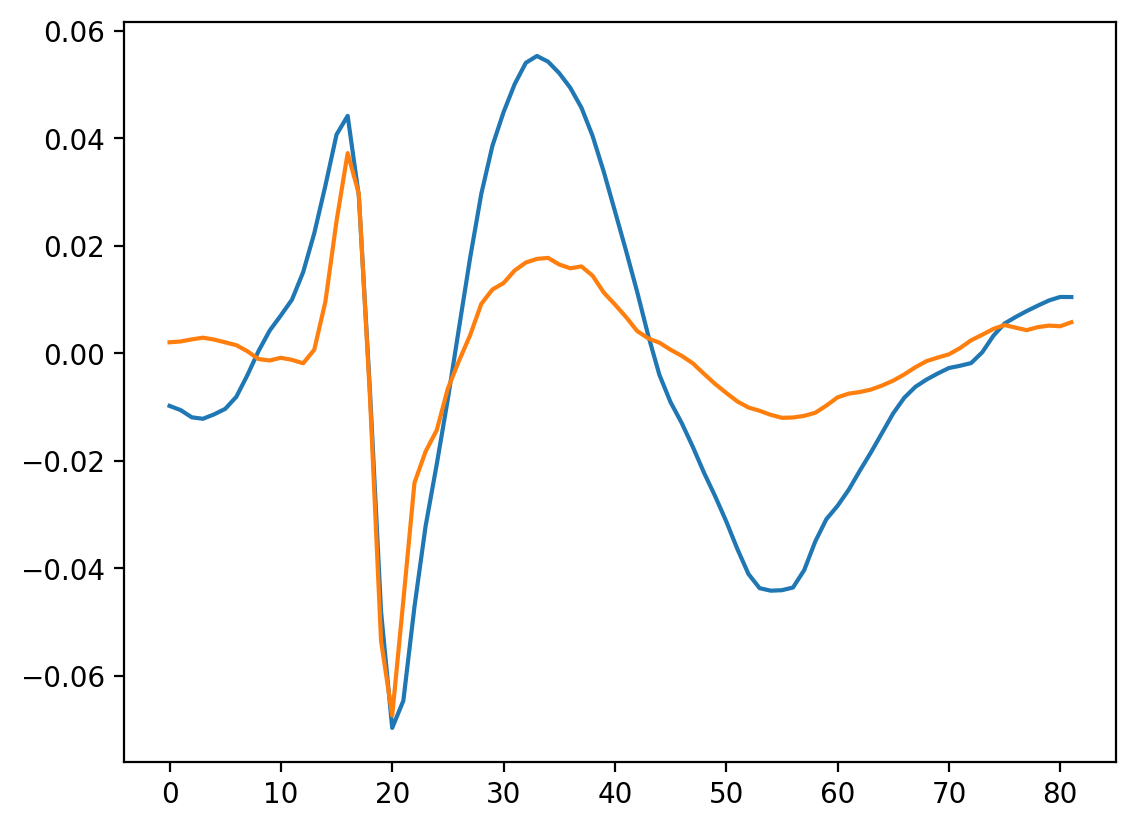

In [19]:
plt.plot(mean_wf_norm[113, 106,:]);
plt.plot(mean_wf_norm[129, 106,:]);

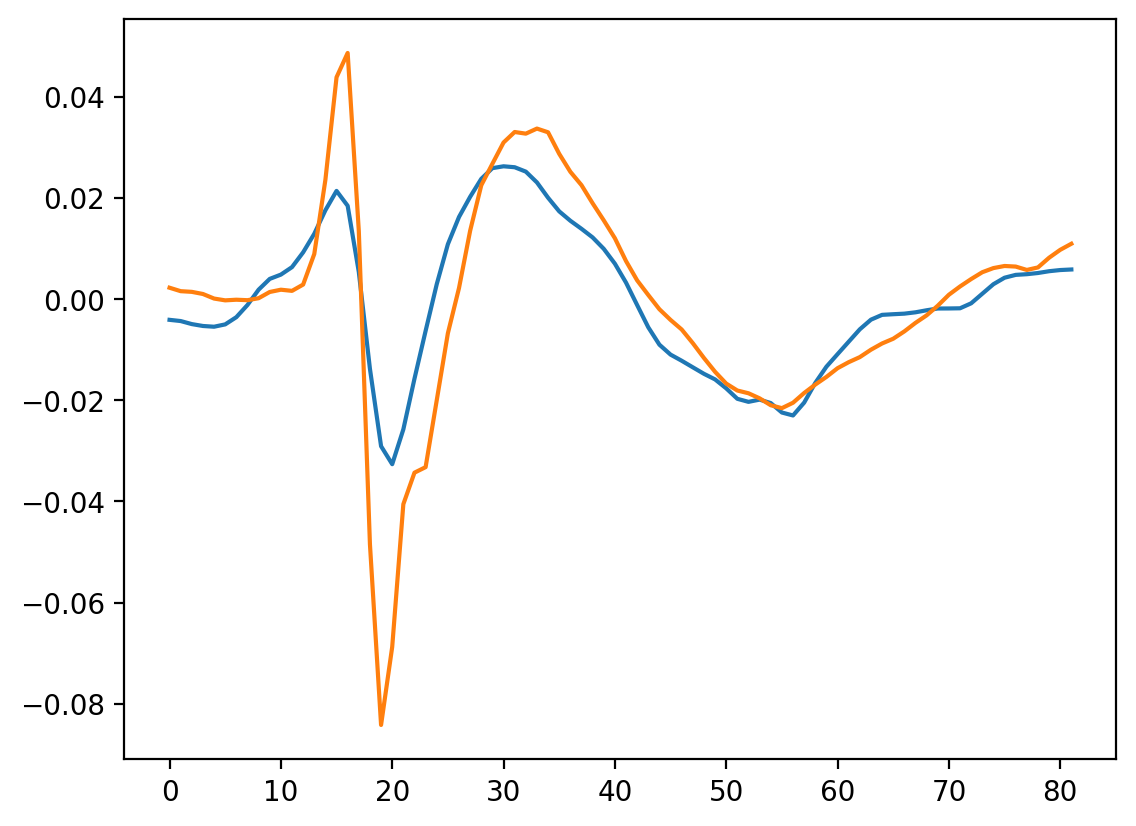

In [20]:
plt.plot(mean_wf_norm[113, 113,:]);
plt.plot(mean_wf_norm[129, 113,:]);

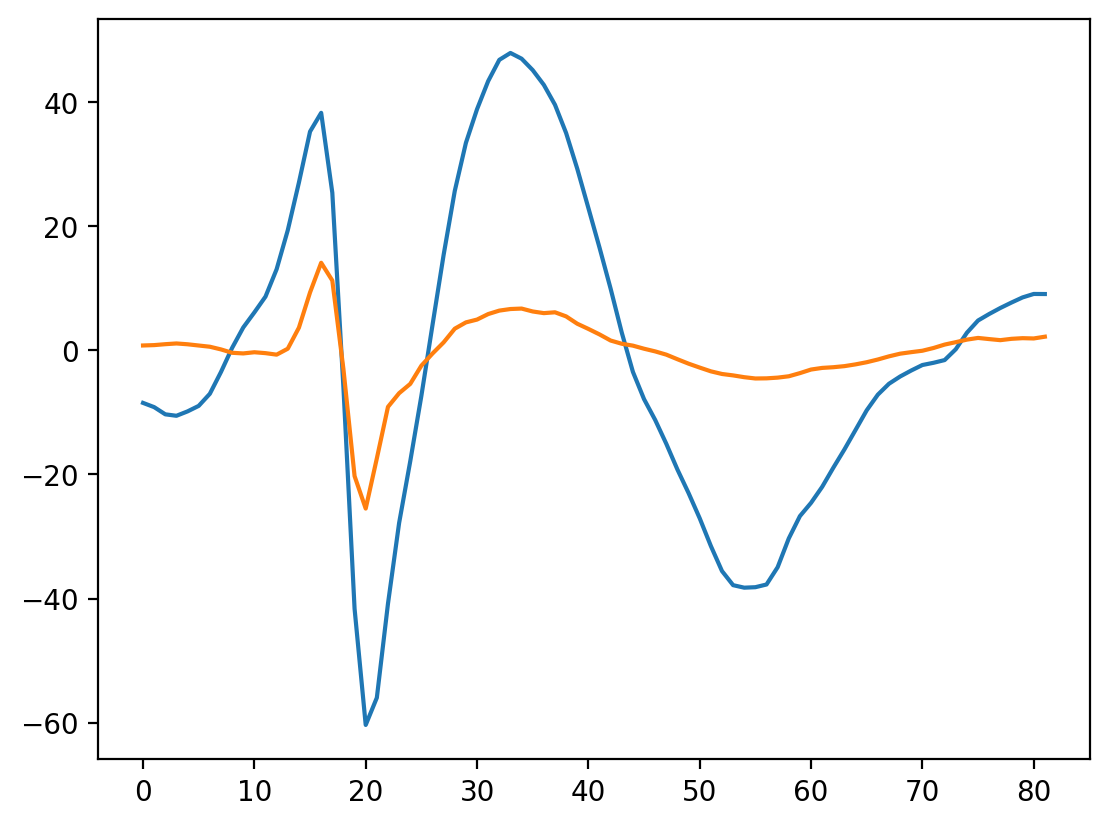

In [21]:
plt.plot(mean_wf[113, 106,:]);
plt.plot(mean_wf[129, 106,:]);

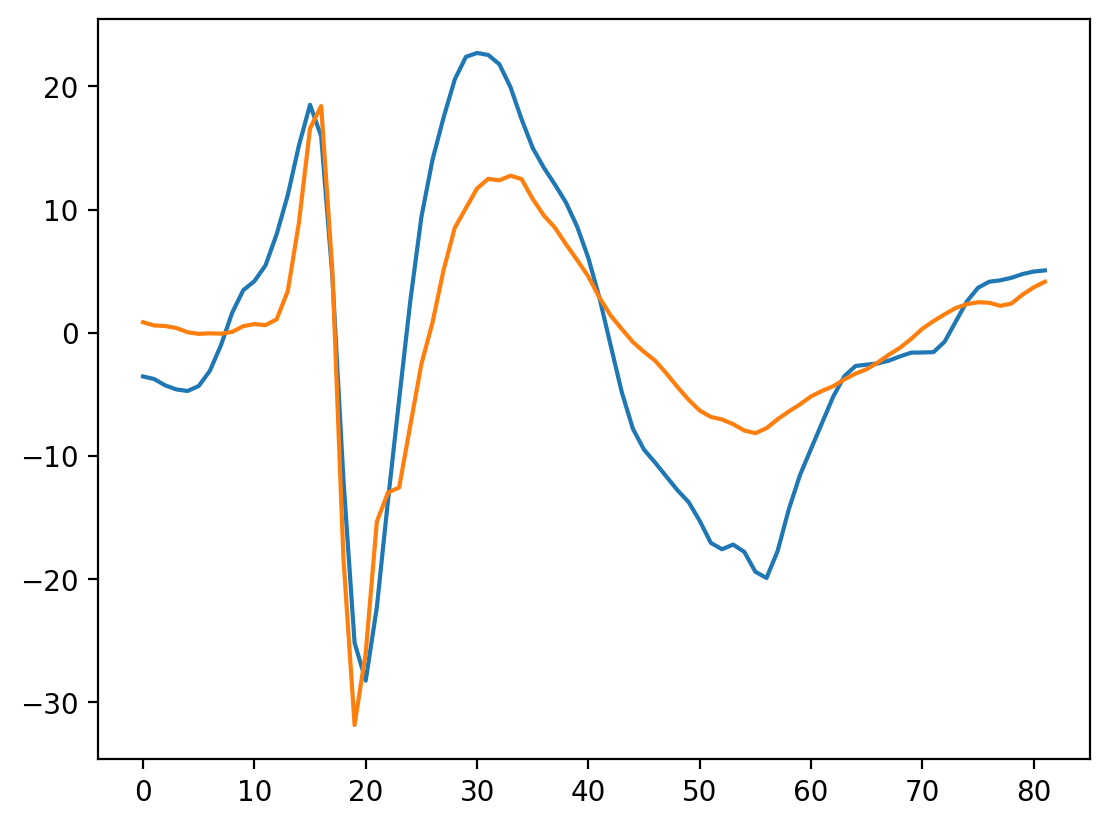

In [22]:
plt.plot(mean_wf[113, 113,:]);
plt.plot(mean_wf[129, 113,:]);

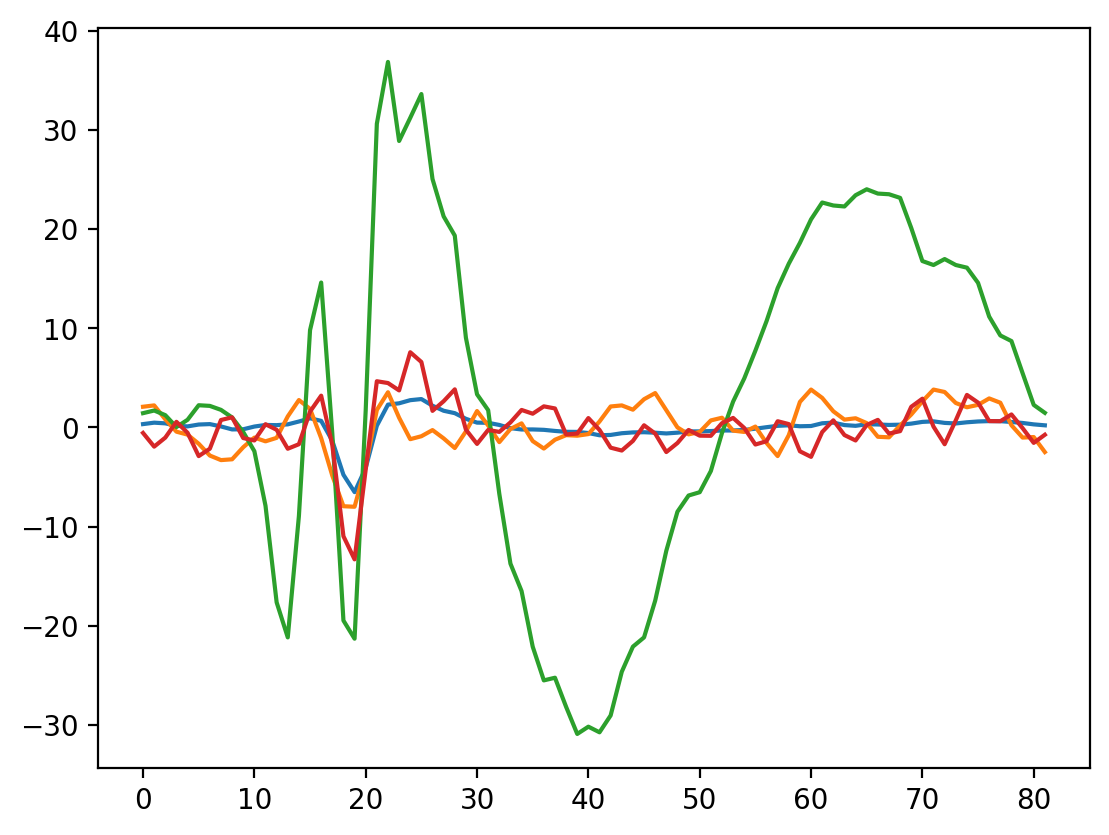

In [27]:
n1 = (wf_means_norm[65]**2).sum()
n2 = (wf_means_norm[66]**2).sum()
n3 = (wf_means_norm[67]**2).sum()
n4 = (wf_means_norm[68]**2).sum()

np.corrcoef(np.vstack((wf_means_norm[65].flatten(), wf_means_norm[66].flatten(), wf_means_norm[67].flatten(), wf_means_norm[68].flatten())))

plt.plot(((mean_wf[65:69, 74,:].T)-np.ones((82,1))@np.array([[+0,0,0,0]]))@np.array([[1,0,0,0],[0,1,0,0],[0,0,1,0],[0,0,0,1]]));


In [28]:
import skimage

In [168]:
from skimage.restoration import (denoise_wavelet, estimate_sigma)
c1 = 66

noisy = mean_wf[c1]
sigma_est = estimate_sigma(noisy, channel_axis=None, average_sigmas=True)

im_visushrink = denoise_wavelet(noisy, channel_axis=None,
                                method='VisuShrink', mode='soft', wavelet="sym4",
                                sigma=sigma_est*2, rescale_sigma=True)

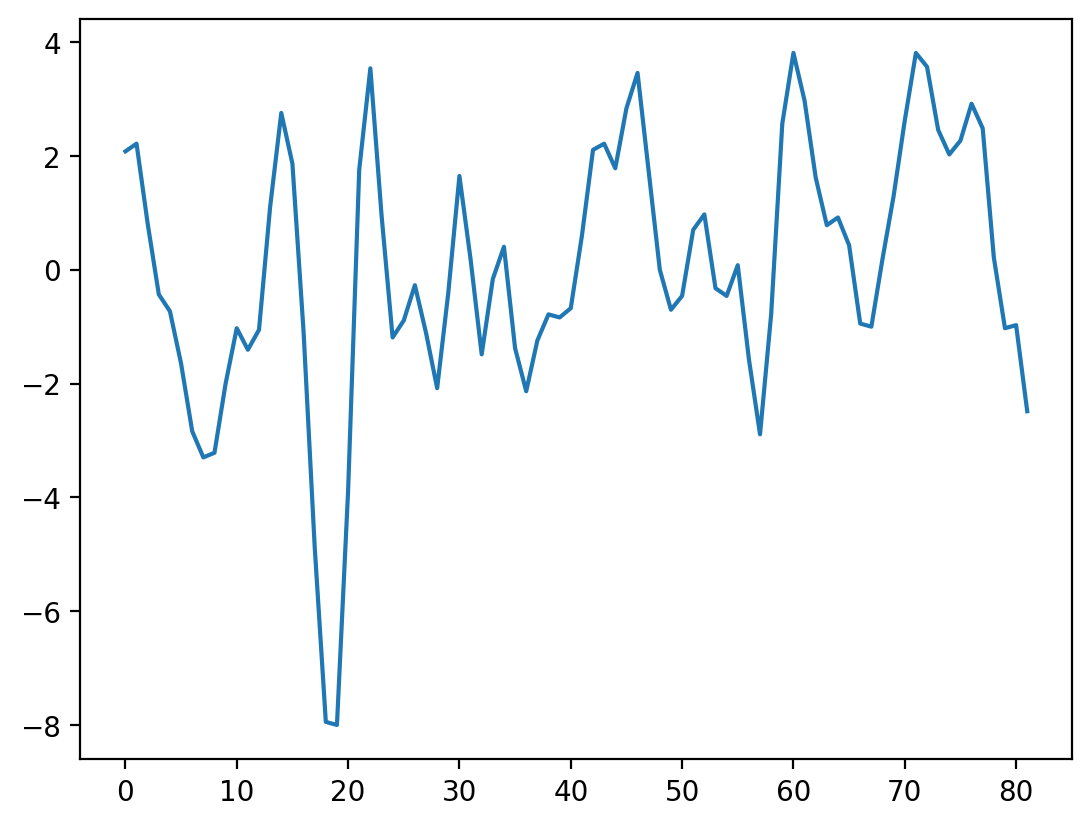

In [166]:
plt.plot(mean_wf[c1, 74,:]);

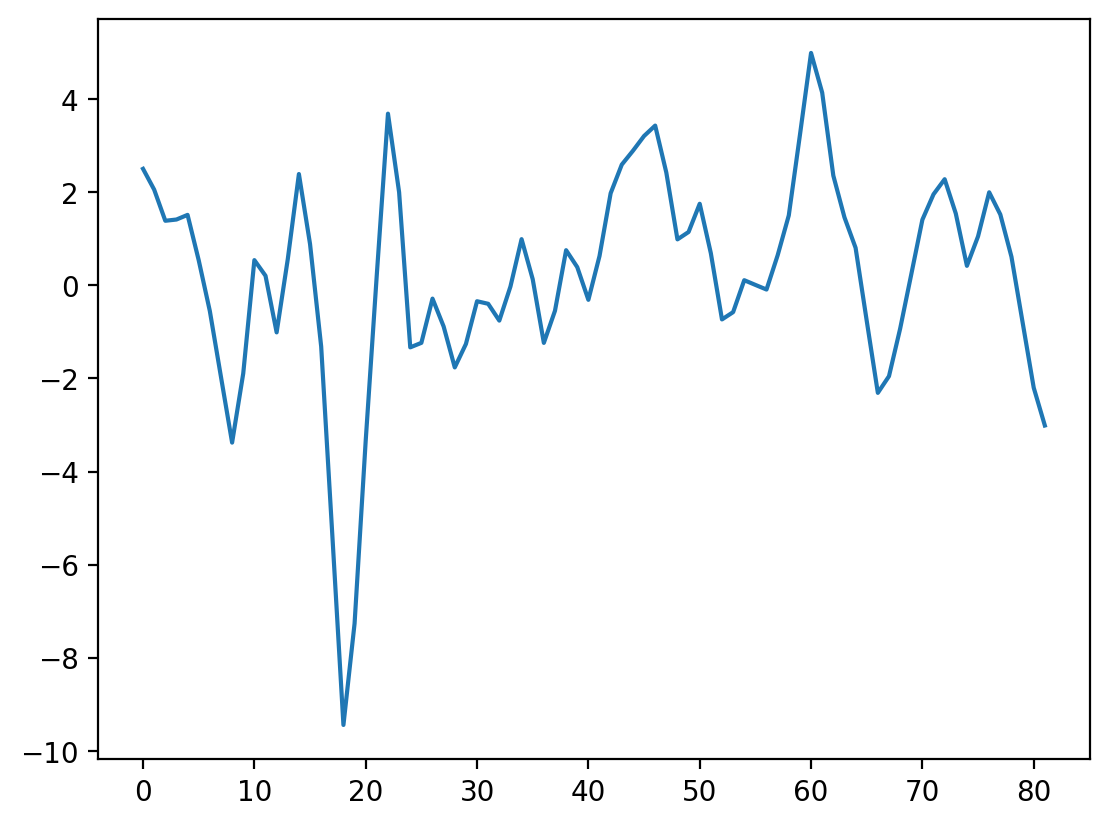

In [ ]:
plt.plot(im_visushrink[74,:]);

In [182]:
mean_wf_den = np.zeros_like(mean_wf)
for c1 in range(mean_wf.shape[0]):
    noisy = mean_wf[c1]
    sigma_est = estimate_sigma(noisy, channel_axis=None, average_sigmas=True)

    mean_wf_den[c1] = denoise_wavelet(noisy, channel_axis=None,
                                    method='VisuShrink', mode='soft', wavelet="sym4",
                                    sigma=sigma_est*5, rescale_sigma=True)

In [183]:
mean_sim_den, offset, wf_means_norm_den = bd.wf_means_similarity(
        mean_wf_den, 
        jitter=params['jitter'],
        jitter_amt=params['jitter_amt']
    )